# Variance estimation on Categorical VAE using VI with Mixture of Discrete Normalizing Flows

A version using the one-file implementation of factorized flows.

Design of the VAE follows the implementation from https://github.com/ericjang/gumbel-softmax

## Imports and Helper Functions

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfpd

import copy
import time
import pandas as pd

In [2]:
tf.__version__, tfp.__version__

('2.2.0', '0.9.0')

In [3]:
import sys
sys.path.append('../mdnf')

In [4]:
import aux

In [5]:
import flows_factorized_mixture

## Configuration

In [6]:
# can be run as a script with args in format KEY=VAL,KEY=[STRVAL],...
args = aux.parse_script_args() 

In [7]:
SEED=args.get("SEED", 0)
OUT=args.get("OUT", "VAEFlows.csv")

# base distribution type (p -> delta)
# see create_base_mixture in base_constructors.py for options
BASE_SPECIFICATION = args.get("BASE_SPECIFICATION", "p") 

B = args.get("B", 40) # how many flows in mixture
N = args.get("N", 10) # how many latent variables
K = args.get("K", 2) # how many categories each

# Temperature hyperparameter
BASE_TEMP = args.get("BASE_TEMP", 100.0)
ANNEAL_RATE = args.get("ANNEAL_RATE", 0.00003)
MIN_TEMP = args.get("MIN_TEMP", 0.001)

OPTIMIZER = args.get("OPTIMIZER", "ADAM")
LR = args.get("LR", 0.001)
BATCH_SIZE=args.get("BATCH_SIZE", 256) # how many samples in minibatch
NUM_ITERS=args.get("NUM_ITERS", 1) # how many epochs

NSAMPLES = args.get("NSAMPLES", 1) # how many samples per data point in each step (=how many ELBOs evaluations)

In [8]:
CFG = ["VAE_FLOWS", SEED, OUT, B, N, K, BATCH_SIZE, NUM_ITERS, 
       BASE_TEMP, None, OPTIMIZER, LR, ANNEAL_RATE, MIN_TEMP]
print("CFG=%s" % CFG)

CFG=['VAE_FLOWS', 0, 'VAEFlows.csv', 40, 10, 2, 256, 1, 100.0, None, 'ADAM', 0.001, 3e-05, 0.001]


## Model

In [9]:
class CategoricalVAE(tf.Module):

    def __init__(self, mixture, N, K, name=None):
        """
        
            Args:
                N  number of variables
                K  number of categories for each variable
                B  number of components in a mixture of flows
        """
        super(CategoricalVAE, self).__init__(name=name)
        
        self.mixture = mixture
        self.base = mixture

        self.N = N # number of categorical distributions
        self.K = K # number of classes
        
        
        self.calc_logits_z = tf.keras.Sequential([ # encoder
                                             tf.keras.layers.Flatten(name="encoder0"),
                                             tf.keras.layers.Dense(512, activation="relu", 
                                                                   input_shape=(None, 784), name="encoder1"),
                                             tf.keras.layers.Dense(256, activation="relu", name="encoder2"),
                                             tf.keras.layers.Dense(K*N, activation=None, name="encoder3"),
                                             tf.keras.layers.Reshape( [N,K] , name="encoder4")
                                            ], name="encoder")

        self.calc_logits_x = tf.keras.Sequential( # decoder
                                            [tf.keras.layers.Flatten(name="decoder0"),
                                             tf.keras.layers.Dense(256, activation="relu", name="decoder1"),
                                             tf.keras.layers.Dense(512, activation="relu", name="decoder2"),
                                             tf.keras.layers.Dense(784, activation=None, name="decoder3"),
                                            ], name="decoder")         
        
        #B = len(mixture.flows)
        B = mixture.logits.shape[1]
        self.calc_logits_flows = tf.keras.Sequential([ 
                                             tf.keras.layers.Flatten(name="flows0"),
                                             tf.keras.layers.Dense(K*N*B, activation="relu", 
                                                                   input_shape=(None, 784), name="flows1"),
                                             tf.keras.layers.Dense(K*N*B, activation=None, name="flows2"),
                                             tf.keras.layers.Reshape( [B,N,K] , name="flows3")
                                            ], name="logits_flows")        
        
    def __call__(self, x):       
        # variational posterior q(z|x), i.e. the encoder 
        # unnormalized logits for N separate K-categorical distributions (shape=(batch_size,N,K))                
        logits_z = self.calc_logits_z(x)        
        
        logits_flows = self.calc_logits_flows(logits_z)
        self.mixture.logits = tf.transpose(logits_flows, [0,2,1,3])
        batch_size = logits_flows.shape[0]
        samples, mask = self.base.sample_extm(batch_size)             
        
        # generative model p(x|z)
        logits_x = self.calc_logits_x(samples)    
        p_x = tfpd.Bernoulli(logits=logits_x)
        
        return p_x, samples
    
    def log_prob(self, samples): # for entropy/KL evaluation
        samples_inv = self.mixture.reverse(samples)
        return self.base.log_prob_ext(samples_inv)[0,:] 
    
    @property
    def temperature(self):
        return self.mixture.temperature
    
    @temperature.setter
    def temperature(self, value):
        self.mixture.temperature = value
    

## Optimizer

In [10]:
OPTIMIZERS = {"RMS": tf.keras.optimizers.RMSprop,
              "ADAM": tf.keras.optimizers.Adam}
if OPTIMIZER not in OPTIMIZERS: raise ValueError("Unknown optimizer!")
optimizer_class = OPTIMIZERS[OPTIMIZER]
optimizer = optimizer_class(learning_rate=LR)

print("optimizer=%s lr=%s" % (optimizer, LR))

optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f8fd384a580> lr=0.001


## Train for certain number of epochs and then estimate variance

In [11]:
# get data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
frmt = lambda images: tf.cast(tf.reshape(images,(-1, 784)), tf.float32)/255.0
x_train, x_test = frmt(x_train), frmt(x_test)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [12]:
def loss_MC(x, p_x, vae, samples): 
    """
        Args:
            samples  Samples from latent representation
    """
    batch_size, N, K = samples.shape
    
    H_q = -vae.log_prob(samples) 
    Eq_logp = tf.reduce_sum(samples*np.log(1./K), [-1,-2])
    KL = -H_q -Eq_logp

    lik = tf.reduce_sum(p_x.log_prob(x), -1) # sums over 784 pixels
    
    #print("lik=%.4f KL=%.4f prior=%.4f entropy_q=%.4f" % 
    #      ( tf.reduce_mean(lik), tf.reduce_mean(KL), tf.reduce_mean(prior_samples), tf.reduce_mean(entropy_q)))
    return tf.reduce_mean(lik), tf.reduce_mean(KL), tf.reduce_mean(Eq_logp), tf.reduce_mean(H_q)

In [13]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [14]:
means, stds = [], []

MODELS = [(10,2),(2,10),(5,10),(10,5),(10,20),(20,10)]    
for N, K in MODELS:
    print("Running for N=%s K=%s" % (N, K))
    
    # init
    temperature = tf.Variable(BASE_TEMP, name="temperature") #!
    mixture = flows_factorized_mixture.FactorizedDiscreteFlowsMixture(N, K, B, temperature=1.0)

    vae = CategoricalVAE(mixture, N, K)
    loss = loss_MC
    results = []
    best_loss, best_vae = float("inf"), None
    i = 0

    # train for some number of iterations
    start = time.time()
    for e in range(NUM_ITERS):

        losses, liks, kls = [], [], []
        for batch_x, labels in train_ds:

            with tf.GradientTape() as tape:              
                l = 0.
                for _ in range(NSAMPLES):
                    p_x, samples = vae(batch_x)                       
                    lik, KL, Eq_logp, H_q = loss(batch_x, p_x, vae, samples)  
                    l += -(lik-KL)                
                l /= NSAMPLES;             
                lik /= NSAMPLES; KL /= NSAMPLES
                losses.append(float(l)); liks.append(float(lik)); kls.append(float(KL));             

            g = tape.gradient(l, list(vae.trainable_variables))
            optimizer.apply_gradients(zip(g, list(vae.trainable_variables)))
            vae.temperature = np.maximum(BASE_TEMP*np.exp(-ANNEAL_RATE*i), MIN_TEMP) 

            if i%100==0:             
                print("[%.1fs] epoch=%i/iteration=%i loss=%.2f (lik=%.2f kl=%.2f Eqlogp=%.2f Hq=%.2f)" % \
                               (time.time()-start, e, i, l, lik, KL, Eq_logp, H_q))
            i += 1
                
            
    ls = []
    for batch_x, labels in train_ds: break    
    for i in range(100):
        p_x, samples = vae(batch_x)                       
        lik, KL, Eq_logp, H_q = loss(batch_x, p_x, vae, samples)  
        l = -(lik-KL)                
        ls.append(l)    
    means.append(np.mean(ls))
    stds.append(np.std(ls))

Running for N=10 K=2
[0.2s] epoch=0/iteration=0 loss=545.57 (lik=-545.48 kl=0.09 Eqlogp=-6.93 Hq=6.84)
[5.8s] epoch=0/iteration=100 loss=199.43 (lik=-198.65 kl=0.78 Eqlogp=-6.93 Hq=6.15)
[11.8s] epoch=0/iteration=200 loss=205.98 (lik=-205.05 kl=0.93 Eqlogp=-6.93 Hq=6.00)
Running for N=2 K=10
[0.1s] epoch=0/iteration=0 loss=543.40 (lik=-543.10 kl=0.30 Eqlogp=-4.61 Hq=4.31)
[7.5s] epoch=0/iteration=100 loss=197.23 (lik=-196.07 kl=1.15 Eqlogp=-4.61 Hq=3.45)
[15.1s] epoch=0/iteration=200 loss=209.02 (lik=-207.86 kl=1.15 Eqlogp=-4.61 Hq=3.45)
Running for N=5 K=10
[0.2s] epoch=0/iteration=0 loss=544.34 (lik=-543.70 kl=0.64 Eqlogp=-11.51 Hq=10.87)
[14.2s] epoch=0/iteration=100 loss=190.98 (lik=-188.13 kl=2.85 Eqlogp=-11.51 Hq=8.66)
[28.1s] epoch=0/iteration=200 loss=203.62 (lik=-201.57 kl=2.05 Eqlogp=-11.51 Hq=9.47)
Running for N=10 K=5
[0.2s] epoch=0/iteration=0 loss=545.74 (lik=-545.28 kl=0.46 Eqlogp=-16.09 Hq=15.64)
[13.4s] epoch=0/iteration=100 loss=191.50 (lik=-188.37 kl=3.13 Eqlogp=-16.

In [15]:
means = np.array(means)
stds = np.array(stds)

In [16]:
import matplotlib 
from matplotlib import pyplot as plt

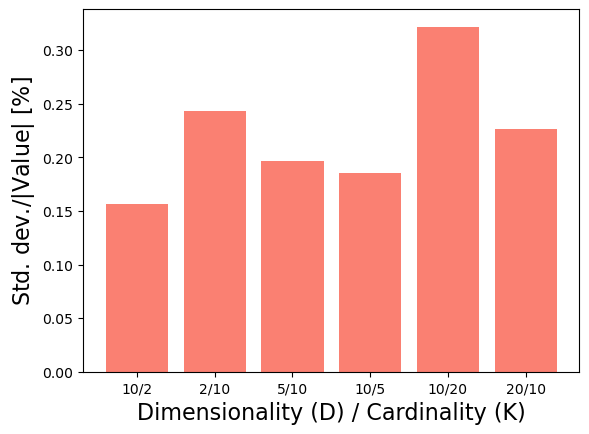

In [22]:
# import sys
# sys.path.append("../experiments")
# from aux_plt import *
#start_plotting(left=0.2)

xs=list(range(len(means)))
plt.bar(xs, 100*stds / means, color="salmon")
plt.xlabel("Dimensionality (D) / Cardinality (K)", fontsize=16)
plt.ylabel(r"Std. dev./$|$Value$|$ [%]", fontsize=16)
plt.xticks(xs, ["%s/%s" % (N,K) for N,K in MODELS]);
plt.savefig("vae_elbo_variance.pdf")
plt.show()

In [19]:
#     grads = []
#     for batch_x, labels in train_ds: break    
#     for i in range(10):
#         with tf.GradientTape() as tape:  
#             p_x, samples = vae(batch_x)                       
#             lik, KL, Eq_logp, H_q = loss(batch_x, p_x, vae, samples)  
#             l = -(lik-KL)                
#         g = tape.gradient(l, list(vae.trainable_variables))
#         grads.append(g)

In [20]:
# for i in range(10):
#     print(grads[i][0].shape)